# Import dependencies

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, SpatialDropout2D, UpSampling2D
from keras.optimizers import RMSprop

from keras.preprocessing import image 
from keras import backend as K
import os
import numpy as np
from keras.applications.resnet50 import preprocess_input
import PIL.ImageOps    
from keras.utils import np_utils
np.random.seed(23)

Using TensorFlow backend.


# Load the Hanacaraka Dataset

('X_train original shape:', (5100, 60, 80, 1))
('X_train shape:', (1000, 60, 80, 1))
(1000, 'train samples')
(1000, 'test samples')
(1000, 60, 80, 1)
(1000, 60, 80, 1)


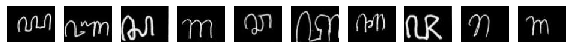

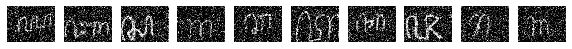

In [2]:
folder = 'gdrive/My Drive/dataset/hanacaraka/'

img_rows, img_cols, img_chns = 60, 80, 1         # input image dimensions
nb_classes = 20
number_of_data = 1000
corruption_level = 0.3

X_train = []
Y_train = []

for cl, fld in enumerate(os.listdir(folder)):
        for f in os.listdir(folder + fld):
                img = image.load_img(folder + fld + '/' + f, 
                                     grayscale=True, target_size=(img_rows, img_cols))     # read image
                img = PIL.ImageOps.invert(img)
                img = image.img_to_array(img)
                X_train.append(img.reshape((img_rows, img_cols, 1)))
                Y_train.append(cl)


X_train = np.array(X_train)
Y_train = np.array(Y_train)

shuffled_indices = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffled_indices] 
Y_train = Y_train[shuffled_indices] 
X_test = X_train[X_train.shape[0]//2:]
X_train = X_train[:X_train.shape[0]//2]

Y_test = Y_train[Y_train.shape[0]//2:]
Y_train = Y_train[:Y_train.shape[0]//2]

print('X_train original shape:', X_train.shape)

if K.image_dim_ordering() == 'th':
    # For Theano backend
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    # For TensorFlow backend
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Split train test
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

X_train = X_train[:number_of_data]
Y_train = Y_train[:number_of_data]
X_test = X_test[:number_of_data]
Y_test = Y_test[:number_of_data]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

## Apply noise to the image
X_train_noisy = X_train + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)
print(X_train_noisy.shape)
print(X_test_noisy.shape)

# Visualize MNIST dataset
import matplotlib.pyplot as plt
%matplotlib inline

n = 10 
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(img_rows, img_cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

import matplotlib.pyplot as plt
%matplotlib inline

n = 10  
plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_noisy[i].reshape(img_rows, img_cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Autoencoder

## Build

In [17]:
# Settings
pool_size = (2, 2)                  # size of pooling area for max pooling
input_shape = (img_rows, img_cols, img_chns)

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(UpSampling2D(pool_size))
model.add(Conv2D(1, (3, 3), padding='same', activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 60, 80, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 40, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 40, 16)        2320      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 80, 1)         145       
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


## Train

In [18]:
# Hyper parameters
batch_size = 128
nb_epoch = 10

model.fit(X_train_noisy, X_train,
                epochs=nb_epoch, batch_size=batch_size, shuffle=True, verbose=1,
                validation_data=(X_test_noisy, X_test))

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6235 - val_loss: 0.5492
Epoch 2/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4989 - val_loss: 0.4326
Epoch 3/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3894 - val_loss: 0.3385
Epoch 4/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3199 - val_loss: 0.3041
Epoch 5/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3042 - val_loss: 0.2988
Epoch 6/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2948 - val_loss: 0.2824
Epoch 7/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2763 - val_loss: 0.2639
Epoch 8/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2586 - val_loss: 0.2468
Epoch 9/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2410 - val_loss: 0.2293
Epoch 10/10
1000/1000 [=========

## Evaluate

In [22]:
evaluation = model.evaluate(X_test_noisy, X_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f' % (evaluation))

1000/1000 [==============================] - 2s 2ms/step
Summary: Loss over the test dataset: 0.21


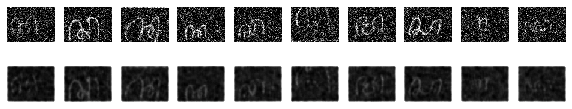

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# Decode test images 
decoded_imgs = model.predict(X_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(10, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(img_rows, img_cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_rows, img_cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()